# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [35]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor

In [32]:
boston = datasets.load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [33]:
y = boston.target
X = boston.data

In [78]:
X_test, y_test = X[-round(X.shape[0]*0.25):].copy(), y[-round(X.shape[0]*0.25):]
X_train, y_train = X[:-round(X.shape[0]*0.25)].copy(), y[:-round(X.shape[0]*0.25)]

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. __После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм__, проигноируйте этот множитель при дальнейшем построении алгоритма.

$s_i = L(\ y_i -   \sum_{n=1}^{N-1}a_{N-1}(x_i) \ )^2$

In [79]:
def s_i(y_true, trees_preds):
    s = [(y_true - pred) for y_true, pred in zip(y_true, trees_preds)]
    return s

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [89]:
from sklearn.metrics import mean_squared_error
def gbm_predict(X, base_algorithms_list, coefficients_list ):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
#(считаем, что base_algorithms_list - список с базовыми алгоритмами
#coefficients_list - список с коэффициентами перед алгоритмами)

In [95]:
def  gradboost_rmse(y_true, X, base_algorithms_list, coefficients_list):
    mse = mean_squared_error(y_true = y_true,
                         y_pred = gbm_predict(
                                             X,
                                             base_algorithms_list,
                                             coefficients_list 
                                             ))
    rmse = mse**0.5
    return rmse
    

In [146]:
def grad_boosting(coeff_reg = 0.0):
           
    base_algorithms_list = []
    coefficients_list = []

    #1. Initialize algorithm
    print('Training initial tree')
    tree = DecisionTreeRegressor(max_depth = 5, random_state = 42)
    tree.fit(X_train, y_train)
    base_algorithms_list.append(tree)
    coefficients_list.append(0.9)
    s = s_i(y_train, gbm_predict(
                                 X_train,
                                 base_algorithms_list,
                                 coefficients_list )
                                 )
    print('RMSE on train: ', gradboost_rmse(y_train, X_train, base_algorithms_list, coefficients_list))
    print('RMSE on test: ', gradboost_rmse(y_test, X_test, base_algorithms_list, coefficients_list))


    #2. Start training
    for i in range(1,50):
        
        print('Training tree:%s'%(i+1))
        # Инициализация дерева
        tree = DecisionTreeRegressor(max_depth = 5, random_state = 42)
        # Обучение
        tree.fit(X_train, s)

        # Добавление дерева в список алгоритмов
        base_algorithms_list.append(tree)
        # Обновление коэффициентов
        if coeff_reg == 0.0:
            pass
        elif coeff_reg == 'iterdec':
             coeff_reg = i
        else:
            coeff_reg = 0.0
        coefficients_list.append(0.9/(1.0 + coeff_reg))
        # Нахождение вектора смещения, расхождения прогноза с истинными значениям целевой переменной
        s = s_i(y_train, gbm_predict(
                                 X_train,
                                 base_algorithms_list,
                                 coefficients_list )
                                 )

        print('RMSE on train: ', gradboost_rmse(y_train, X_train, base_algorithms_list, coefficients_list))
        print('RMSE on test: ', gradboost_rmse(y_test, X_test, base_algorithms_list, coefficients_list))
        
grad_boosting()

Training initial tree
RMSE on train:  3.5105268500764284
RMSE on test:  4.674470252481672
Training tree:2
RMSE on train:  1.7754176396348007
RMSE on test:  5.141717949778777
Training tree:3
RMSE on train:  1.4434182513469662
RMSE on test:  5.124049626080035
Training tree:4
RMSE on train:  1.2144273662749985
RMSE on test:  5.242437481253342
Training tree:5
RMSE on train:  1.0444641308940443
RMSE on test:  5.3280819452726655
Training tree:6
RMSE on train:  0.893654627756842
RMSE on test:  5.4446917942018205
Training tree:7
RMSE on train:  0.7357428153716278
RMSE on test:  5.484426426922022
Training tree:8
RMSE on train:  0.6615040843742869
RMSE on test:  5.500460014011734
Training tree:9
RMSE on train:  0.5971593777491764
RMSE on test:  5.445559878981753
Training tree:10
RMSE on train:  0.5413125613833959
RMSE on test:  5.461576392113825
Training tree:11
RMSE on train:  0.4849711680345235
RMSE on test:  5.458524973538355
Training tree:12
RMSE on train:  0.4158477101986377
RMSE on test:  

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [104]:
grad_boosting(coeff_reg = 'iterdec')

Training initial tree
RMSE on train:  3.5105268500764284
RMSE on test:  4.674470252481672
Training tree:2
RMSE on train:  2.421141379951146
RMSE on test:  4.86124886818998
Training tree:3
RMSE on train:  1.4860926153959648
RMSE on test:  5.21596679588006
Training tree:4
RMSE on train:  1.3278440125834459
RMSE on test:  5.004367210820747
Training tree:5
RMSE on train:  1.1495411262499613
RMSE on test:  4.955071554614163
Training tree:6
RMSE on train:  0.9278846983813908
RMSE on test:  5.116820324600386
Training tree:7
RMSE on train:  0.84909572327489
RMSE on test:  5.121085036438892
Training tree:8
RMSE on train:  0.7936466044662265
RMSE on test:  4.9793017137388995
Training tree:9
RMSE on train:  0.7181754691605425
RMSE on test:  4.978617610403722
Training tree:10
RMSE on train:  0.6801672624813904
RMSE on test:  5.135955510120968
Training tree:11
RMSE on train:  0.5807474124760632
RMSE on test:  5.253787832058132
Training tree:12
RMSE on train:  0.49169980671930097
RMSE on test:  5.24

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

   1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно. **Нет**


   2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться. **Да**


   3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться. **Да**


   4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться **Нет**

In [143]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [138]:
def plot_scores(optimizer):
    scores = [[item[0]['n_estimators'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

In [140]:
gboost = GradientBoostingRegressor()
param_grid = {'n_estimators': [5, 10, 20, 30, 50, 80, 150, 300, 500, 800]}
cv = 5

In [141]:
optimizer = GridSearchCV(estimator = gboost,
                         param_grid = param_grid,
                         cv = cv,
                         verbose = True)
optimizer.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 30, 50, 80, 150, 300, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

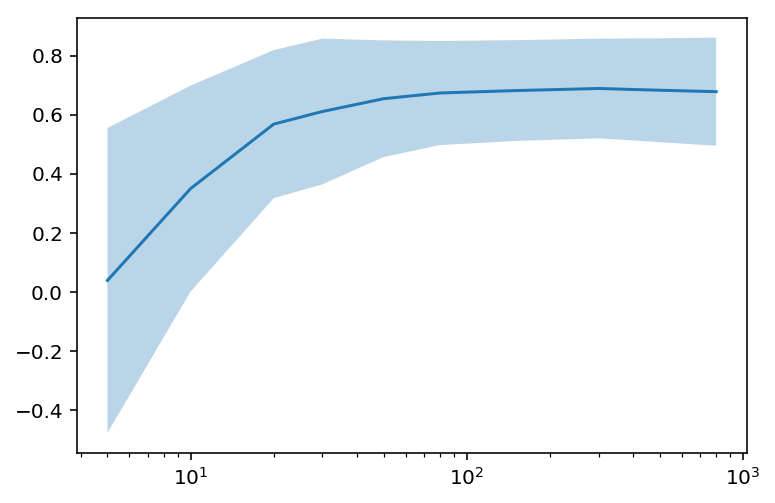

In [144]:
plot_scores(optimizer)

In [160]:
error = []
trees = [x for x in range(1,1000) if x%10==0]
for param in trees :
    gboost = GradientBoostingRegressor(n_estimators = param)
    gboost.fit(X_train, y_train) 
    mse = mean_squared_error(y_test,gboost.predict(X_test))
    if param%50 ==0:
        print('Trees:%s|MSE:%s'%(param, mse))
    else:
        pass
    error.append(mse) 

Trees:50|MSE:21.255196006033643
Trees:100|MSE:19.976306858051757
Trees:150|MSE:19.40916965645844
Trees:200|MSE:19.494769771368087
Trees:250|MSE:20.417201238316956
Trees:300|MSE:18.796506512238576
Trees:350|MSE:20.164354203397785
Trees:400|MSE:19.699885787057703
Trees:450|MSE:19.157232225813186
Trees:500|MSE:19.653349833892197
Trees:550|MSE:19.77724071574759
Trees:600|MSE:19.703514383853605
Trees:650|MSE:19.038860258356127
Trees:700|MSE:19.140997465116765
Trees:750|MSE:19.45116208943234
Trees:800|MSE:19.39647690084
Trees:850|MSE:20.08011149432955
Trees:900|MSE:19.158366090076594
Trees:950|MSE:19.843785853754625


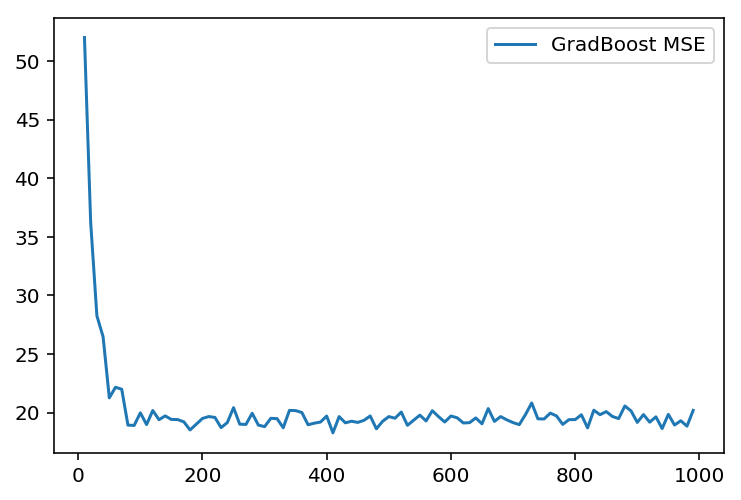

In [161]:
plt.plot(trees,error, label = 'GradBoost MSE' )
plt.legend()
plt.show()

In [163]:
error = []
depths = [x for x in range(1,100)]
for depth in depths :
    gboost = GradientBoostingRegressor(n_estimators = 50, max_depth = depth)
    gboost.fit(X_train, y_train) 
    mse = mean_squared_error(y_test,gboost.predict(X_test))
    error.append(mse) 

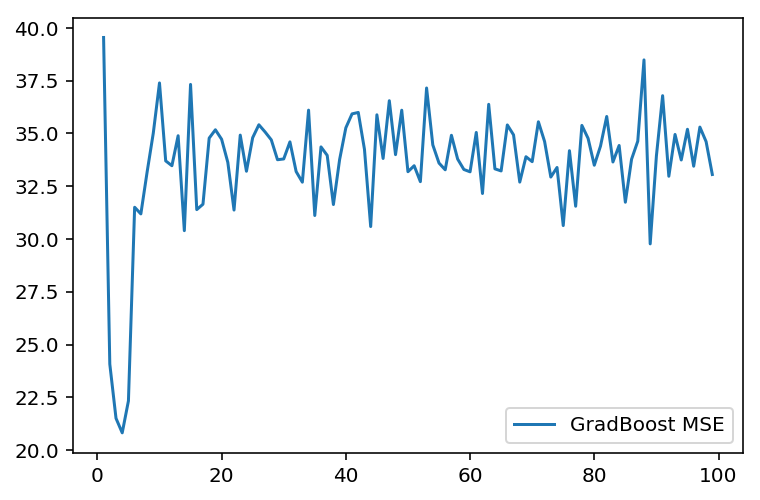

In [164]:
plt.plot(depths ,error, label = 'GradBoost MSE' )
plt.legend()
plt.show()

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [165]:
from sklearn.linear_model import LinearRegression

In [166]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [168]:
mean_squared_error(y_test,linreg.predict(X_test))**0.5

7.848121796479828

In [169]:
def write_answer(text, name):
    with open(str(name), "w") as fout:
        fout.write(str(text))

In [170]:
write_answer(5.455472074527531 ,'gboost_ans2.txt')

In [171]:
write_answer(5.236453649504835 ,'gboost_ans3.txt')

In [174]:
write_answer('2 3' ,'gboost_ans4.txt')

In [173]:
write_answer(7.848121796479828 ,'gboost_ans5.txt')